In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

## Model

The Jump-Diffusion model is the following:

$$
\begin{aligned}
Z_{t+\Delta t} &= Z_t + (\theta + \kappa Z_t) \Delta t + \sigma_z \sqrt{Z_t} \Delta W_t^z + V_{t+\Delta t}^z J_{t+\Delta t} \\
X_{t+\Delta t} &= X_t + \alpha \Delta t + \sqrt{Z_t} \Delta W_t^x + V_{t+\Delta t}^x J_{t+\Delta t} 
\end{aligned}
$$

where

$$
\begin{aligned}
\Delta W_t^x, \Delta W_t^z &\sim \textrm{iid } N(0, \Delta t) \\
V_t^z &\sim \exp(\mu_z) \\
V_t^x &\sim N(\mu_x, \sigma^2_x) \\
J_{t+\Delta t} &\sim \textrm{Bern}(\lambda \Delta t).
\end{aligned}
$$

Thus, our parameters are $\Theta = (\alpha, \theta, \kappa, \sigma_z, \lambda,\mu_x, \sigma_x, \mu_z)$, observation is $X_t$ (the logarithm of asset price), and latent state $Z_t$ (unobserved volatility).

In [61]:
def euler_sim_jump(key, x, dt, drift_diff, jump, theta):
    """
    Simulate SDE with dense diffusion using Euler-Maruyama discretization.
    Args:
        key: PRNG key.
        x: Initial value of the SDE.  A vector of size `n_dims`.
        dt: Interobservation time.
        drift: Drift function having signature `drift(x, theta)` and returning a vector of size `n_dims`.
        diff: Diffusion function having signature `diff(x, theta)` and returning a vector of size `n_dims`.
        theta: Parameter value.
    Returns:
        Simulated SDE values. A vector of size `n_dims`.
    """
#     key_diff, key_jump = random.split(key)    
    _, diff_subkey, jump_subkey = random.split(key, 3)
    diff_process = drift_diff(diff_subkey, x, theta, dt)
    jump_process = jump(jump_subkey, x, theta, dt)
#     return jnp.append(diff_process + jump_process, jump_process)
    return diff_process + jump_process


class SDEModel_tmp(object):
    
    def __init__(self, dt, n_res, meas_model="Error-free"):
        self._dt = dt
        self._n_res = n_res
        self._meas_model = meas_model
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift_diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def is_valid_state(self, x, theta):
        return True

In [62]:
class JumpDiff(SDEModel_tmp):
    
    def __init__(self, dt, n_res, bootstrap=False):
        super().__init__(dt, n_res)
        self._dt = dt
        self._n_res = n_res
        self._n_state = (self._n_res, 2)
        
    def drift(self, x, theta):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        return mu
    
    def diff(self, x, theta):
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        keys = random.split(key, 3)
        is_jump = jax.random.bernoulli(keys[0,], p=theta[4]*dt)
        jump_process = jnp.where(is_jump==1.0, 
                                 jnp.array([theta[7]*jax.random.exponential(keys[1,]), 
                                            theta[5] + theta[6]*jax.random.normal(keys[2,])]),
                                 jnp.array([0.0,0.0]))
        return jump_process
    
    def get_x(self, x):
        X = x[:2]
        jump = x[2:]
        return X, jump
    
    def get_theta(self, theta):
        X_params = theta[:4]
        jump_params = theta[4:]
        #al, th, ka, sig_z, la, mu_x, sig_x, mu_z = theta
        return X_params, jump_params
    
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]
    
    def meas_lpdf(self, y_curr, x_curr, theta):
        return 1.0

    def state_lpdf(self, x_curr, x_prev, theta):
        r"""
        Sample from Euler transition density: `p(x_curr | x_prev, theta)`
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(diff(x_prev, theta)[1,1])
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=dt/n_res,
                          drift=drift,
                          diff=diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    
    def pf_step(self, key, x_prev, y_curr, theta):
        """
        Update particle and calculate log-weight for a bootstrap particle filter.

        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.

        Returns:
            - x_curr: Sample of the state variable at current time `t`: `x_curr ~ q(x_curr)`.
            - logw: The log-weight of `x_curr`.
        """
        x_curr = self.state_sample(key, x_prev, theta)
        logw = lax.cond(
            self.is_valid_state(x_curr, theta),
            lambda _x: self.meas_lpdf(y_curr, x_curr, theta),
            lambda _x: -jnp.inf,
            0.0
        )
        return x_curr, logw
    
    def pf_init(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = y_init + random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init]), axis = 0), axis=0), \
            logw
    
    def pf_init2(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = jnp.log(y_init + random.normal(
            subkey,
            shape=(self._n_state[1],)
        ))
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + x_init.shape),
                       jnp.expand_dims(x_init, axis=0), axis=0), \
            logw

In [46]:
key = random.PRNGKey(0)

dt = 1
n_res = 5
n_obs = 100
theta = jnp.array([0.08, 0.02, -0.03, 0.12, 0.05, -3.1, 2.7, 1.7])
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.array([2.0, 100.0])]])

jdmodel = JumpDiff(dt, n_res)

In [47]:
y_meas, x_state = pf.simulate(jdmodel, key, n_obs, x_init, theta)

In [28]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

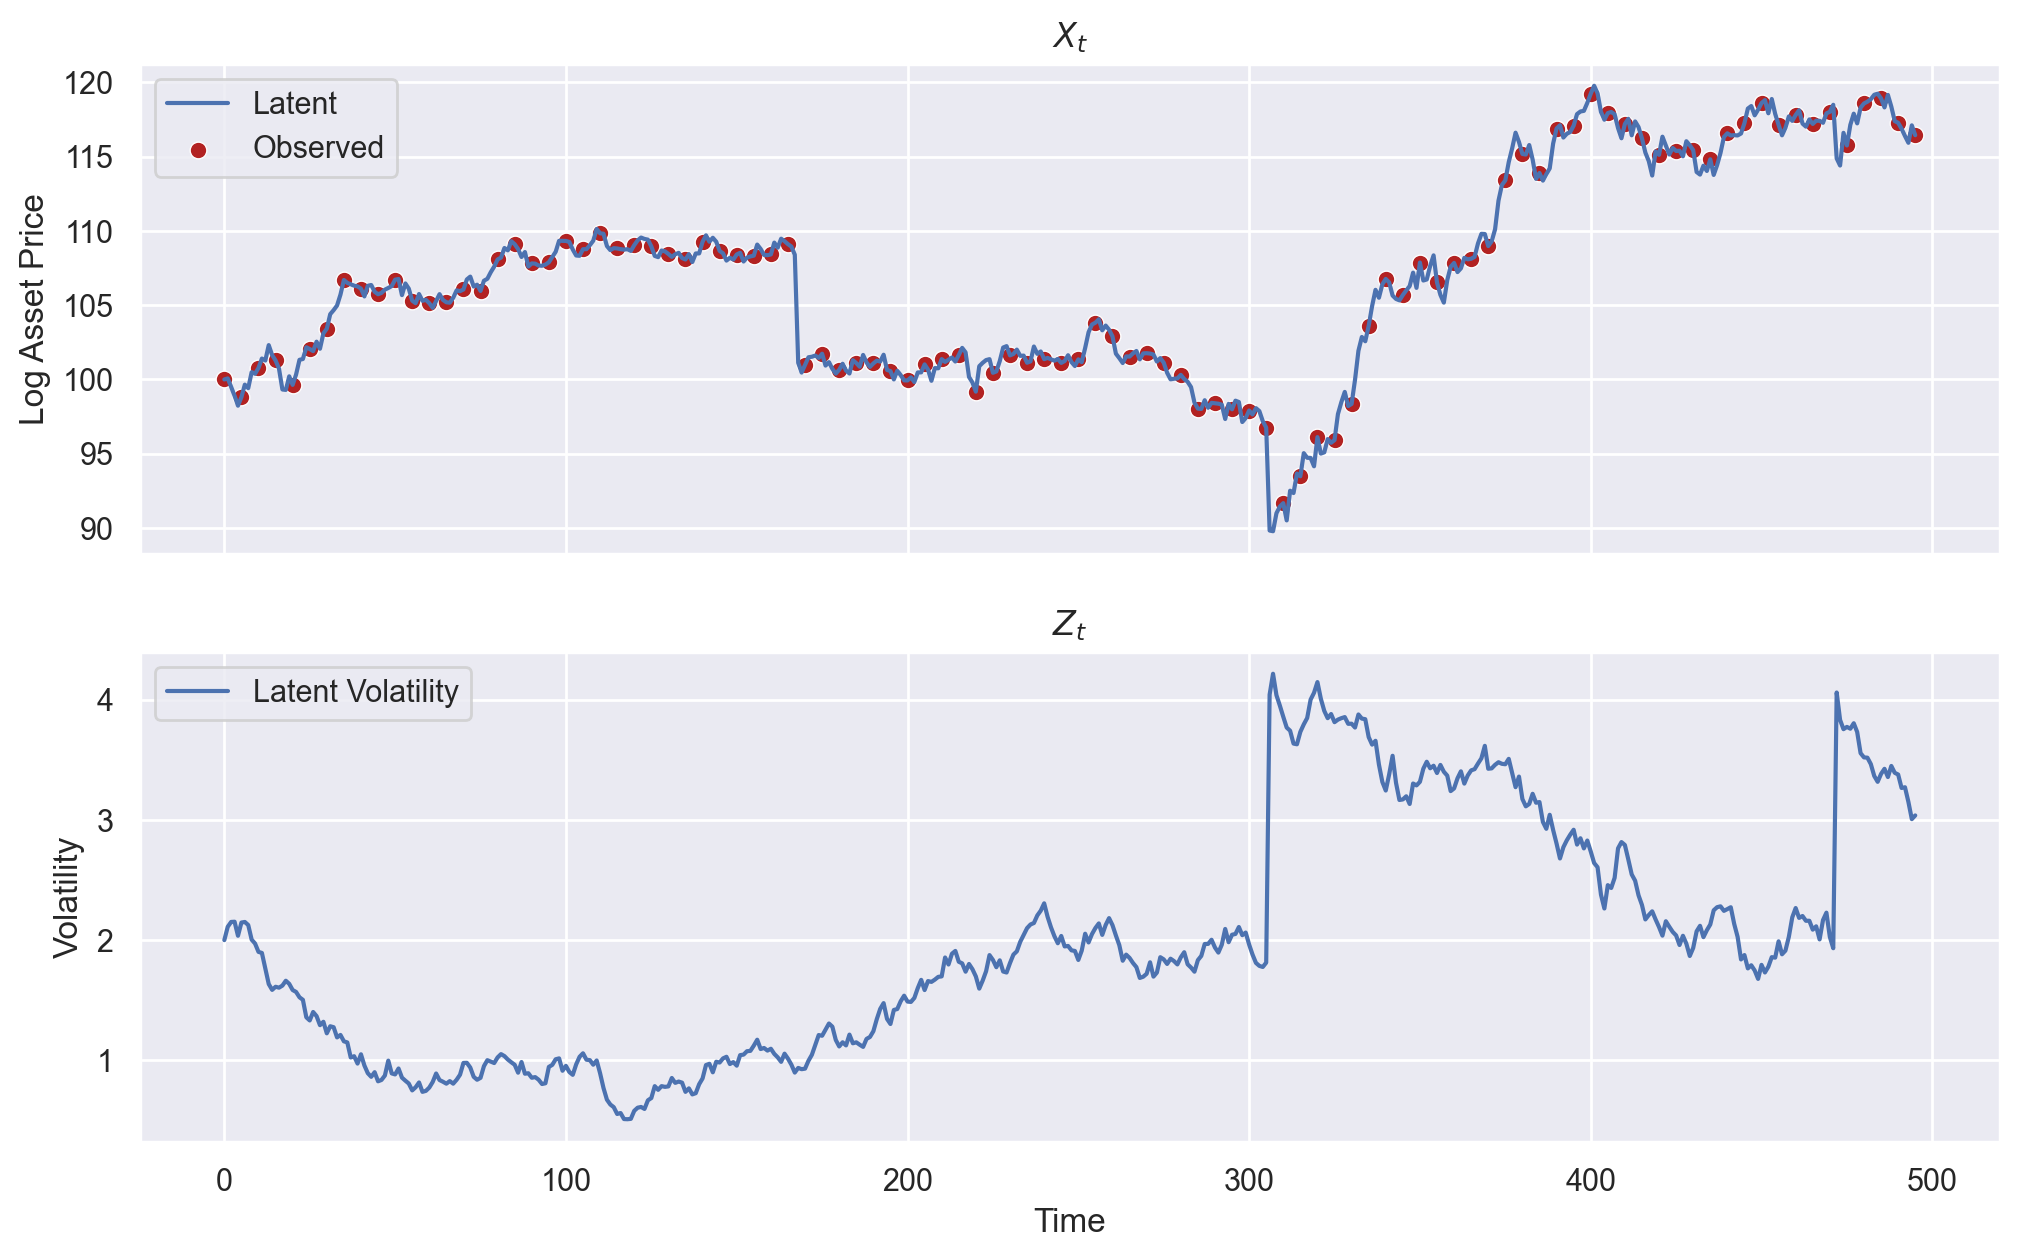

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");

# plt.plot(y_meas)
sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");
# sns.lineplot(data= x_state[..., 2].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
#              ax = ax[1],
#              label = "Vol jumps")
# sns.lineplot(data= x_state[..., 3].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
#              ax = ax[1],
#              label = "Price jumps");

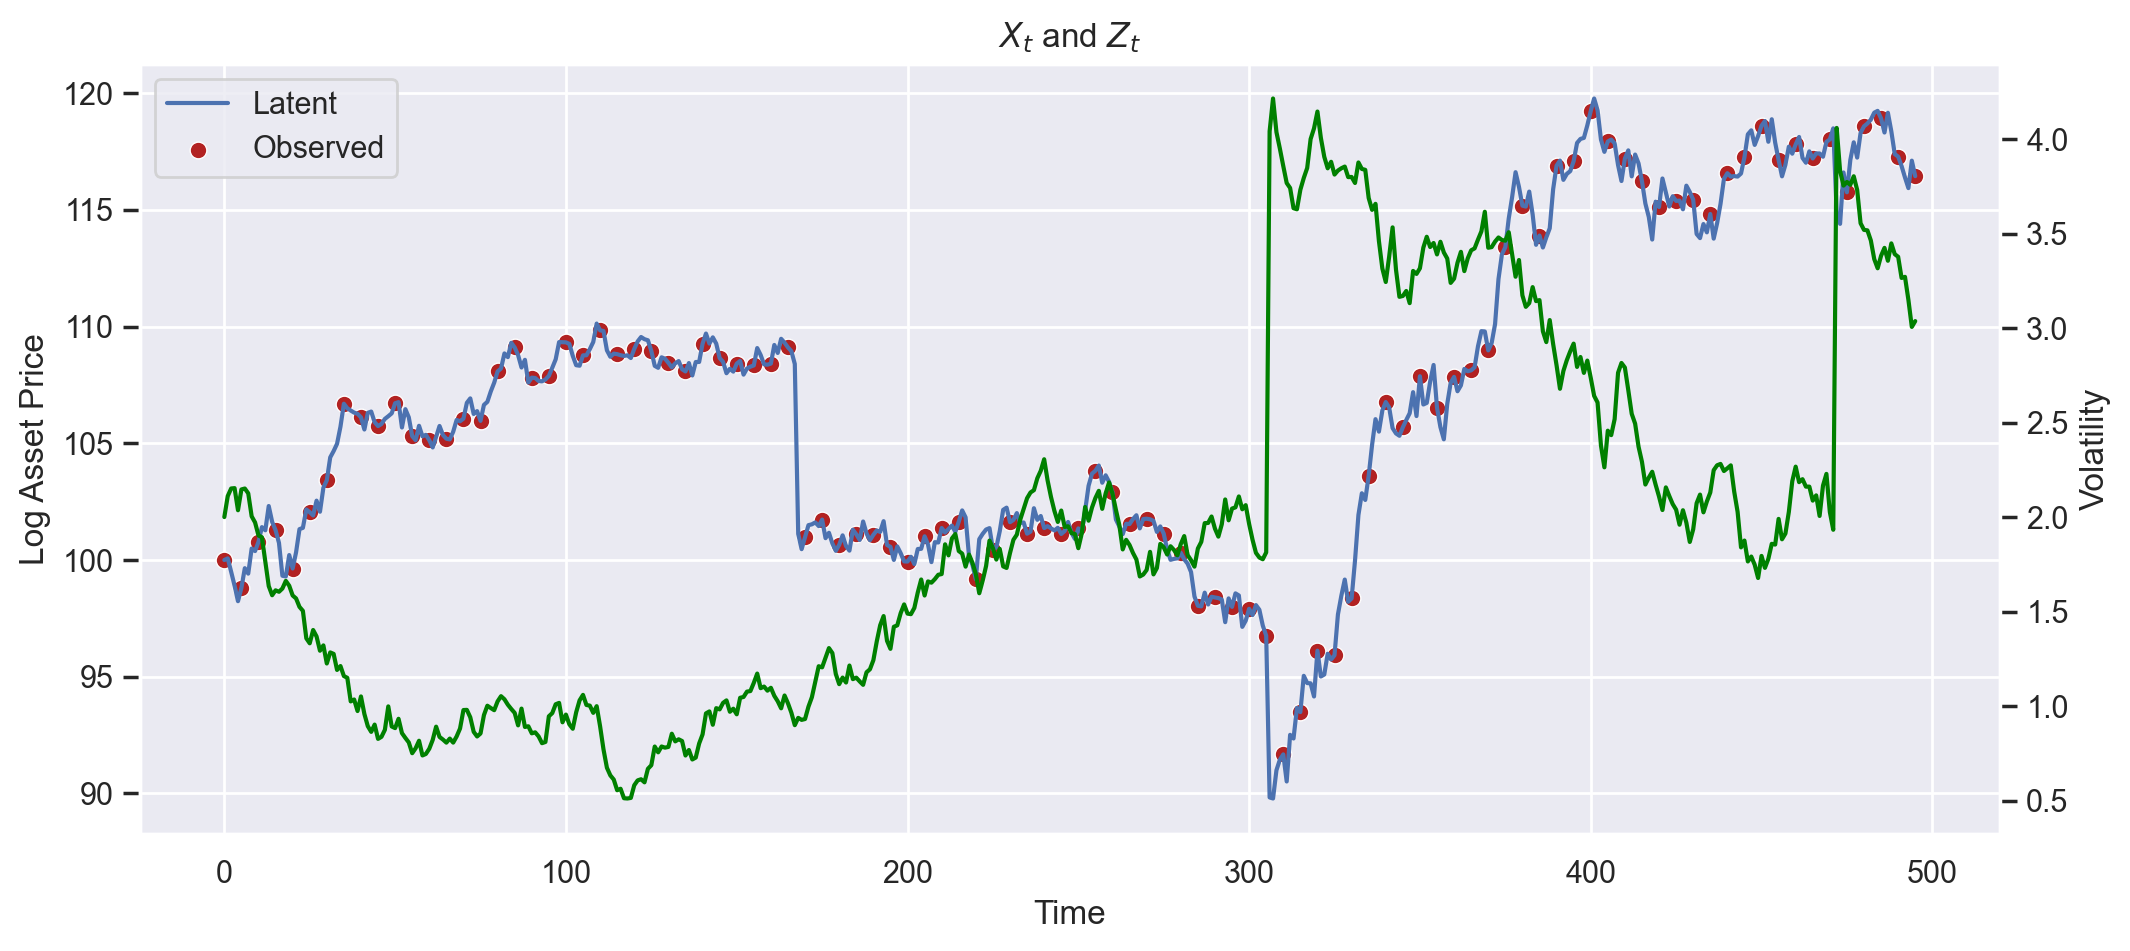

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharey = False)
ax2 = ax.twinx()

sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
             ax = ax,
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax,
                label="Observed").set(title ="$X_t$ and $Z_t$");

# plt.plot(y_meas)
with sns.axes_style("whitegrid"):
    ax2.set_facecolor('white');
    ax2.grid(False)
    sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
                 ax = ax2, color = "green").set(ylabel="Volatility");

## Bridge 

This is essentially a different set of code from above...

In [ ]:
def bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res):
    k = n_res - n
    dt_res = dt/n_res
    
    mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
    sig2_z = x[0]*(theta[3]**2)*dt_res
    
    mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
    sig2_x = (k - 1)/k*x[0]*dt_res
    
    return mu_z, sig2_z, mu_x, sig2_x

In [ ]:
def bridge_step_lean(key, x_prev, y_curr, theta):
        
    def scan_fun(carry, t):
        key = carry["key"]
        x = carry["x"]
        
        n, vz, vx, vx_invcumsum = t
        mu_z, sig2_z, mu_x, sig2_x = bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res)

        key, subkey1, subkey2 = random.split(key,3)
        
#         x_prop = jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(subkey1),
#                             jnp.where(n<n_res-1, 
#                                       mu_x + jnp.sqrt(sig2_x) * random.normal(subkey2),
#                                       y_curr),
#                             vz, vx])
        x_prop = jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(subkey1),
                            jnp.where(n<n_res-1, 
                                      mu_x + jnp.sqrt(sig2_x) * random.normal(subkey2),
                                      y_curr)])

        lp_prop = jnp.where(n<n_res-1,
                            jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                            0.0)
        
        res_carry = {
            "x": x_prop,
            "key": key,
            "lp": carry["lp"] + lp_prop
        }

        res_stack = {"x": x_prop, "lp":lp_prop}

        return res_carry, res_stack
    
    scan_init = {
        "x": x_prev[n_res-1],
        "key": key,
        "lp": jnp.array(0.)
    }
    
    key, key_jump, key_z, key_x = random.split(key, 4)
    
    ns = jnp.arange(n_res)
    jumps = jax.random.bernoulli(key_jump, shape=(n_res,), p=theta[4]*dt/n_res)
    vzs = theta[7]*jax.random.exponential(key_z, shape=(n_res,))*jumps
    vxs = (theta[5]+theta[6]*jax.random.normal(key_x, shape=(n_res,)))*jumps
    #vzs = jax.vmap(lambda x: jnp.where(x, theta[7]*jax.random.exponential(key_z), 0.0))(jumps)
    #vxs = jax.vmap(lambda x: jnp.where(x, theta[5]+theta[6]*jax.random.normal(key_x), 0.0))(jumps)
    vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
    
    last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
    
    x_prop = full["x"]
    
    logw_trans = state_lpdf_lean(
        x_curr=x_prop,
        x_prev=x_prev, 
        theta=theta
    )
    
    logw = logw_trans - full["lp"]
    
    return x_prop, logw

In [ ]:
def drift(x, theta):
    mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
    return mu

def diff(x, theta):
    Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
    return Sigma

def euler_lpdf_jump_lean(x_curr, x_prev, dt, drift, diff, theta):
    return jsp.stats.norm.logpdf(
        x=x_curr[1],
        loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
        scale=jnp.sqrt(diff(x_prev, theta)[1,1])
    ) 

def state_lpdf_lean(x_curr, x_prev, theta):
    x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
    x1 = x_curr
    lp = jax.vmap(lambda xp, xc:
                  euler_lpdf_jump_lean(
                      x_curr=xc, x_prev=xp,
                      dt=dt/n_res,
                      drift=drift,
                      diff=diff,
                      theta=theta))(x0, x1)
    return lp

## Particle Filter - dont waste your time in this section

In [ ]:
def logw_to_prob(logw):
    r"""
    Calculate normalized probabilities from unnormalized log weights.
    Args:
        logw: Vector of `n_particles` unnormalized log-weights.
    Returns:
        Vector of `n_particles` normalized weights that sum to 1.
    """
    wgt = jnp.exp(logw - jnp.max(logw))
    prob = wgt / jnp.sum(wgt)
    return prob

def resample_multinomial(key, x_particles_prev, logw):
    prob = logw_to_prob(logw)
    n_particles = logw.size
    ancestors = random.choice(key,
                              a=jnp.arange(n_particles),
                              shape=(n_particles,), p=prob)
    return {
        "x_particles": x_particles_prev[ancestors, ...],
        "ancestors": ancestors
    }

In [ ]:
bridge_prop = jax.vmap(lambda x, y: bridge_step_lean(key, 
                                                     x_prev=x, 
                                                     y_curr=y, 
                                                     theta=theta), 
                       in_axes = (0, None))
x_prop, bridge_weights = bridge_prop(x_particles_prev, y_meas[0])

In [ ]:
w_tilde

In [ ]:
# Step through particle filter: 

# initialize: 
n_particles = 50
x_particles_prev = jnp.abs(random.normal(key, shape = (n_particles, n_res, 2))) # initial particles
w = 1/jnp.arange(n_particles)

# propose: 
bridge_prop = jax.vmap(lambda x, y: bridge_step_lean(key, 
                                                     x_prev=x, 
                                                     y_curr=y, 
                                                     theta=theta), 
                       in_axes = (0, None))
x_prop, bridge_weights = bridge_prop(x_particles_prev, y_meas[0])
bridge_weights = jnp.sum(bridge_weights, axis = 1)

# re-weight: p_{trans}(X_t | X_{t-1}) / p_{prop}(X_t | X_{t-1})
jd_lpdf = jax.vmap(lambda x_curr, x_prev: jnp.sum(state_lpdf_lean(
    x_curr=x_curr, 
    x_prev=x_prev, 
    theta=theta)),
                  in_axes=(0, 0))
w_tilde = jd_lpdf(x_prop, x_particles_prev) - bridge_weights

# re-sample: 
resample_dict = resample_multinomial(key, x_particles_prev = x_prop, logw = w_tilde)

In [ ]:
# plot proposed particles and weights: 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
             ax = ax,
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax,
                label="Observed").set(title ="$X_t$")
ax.scatter(x=[1]*n_particles, y=x_prop[:, 4, 1], color = "orange");

In [ ]:
# propose: 
x_prop2, bridge_weights = bridge_prop(resample_dict["x_particles"], y_meas[0])
bridge_weights = jnp.sum(bridge_weights, axis = 1)

# re-weight: p_{trans}(X_t | X_{t-1}) / p_{prop}(X_t | X_{t-1})
jd_lpdf = jax.vmap(lambda x_curr, x_prev: jnp.sum(state_lpdf_lean(
    x_curr=x_curr, 
    x_prev=x_prev, 
    theta=theta)),
                  in_axes=(0, 0))
w_tilde = jd_lpdf(x_prop2, resample_dict["x_particles"]) - bridge_weights

# re-sample: 
resample_dict = resample_multinomial(key, x_particles_prev = x_prop2, logw = w_tilde)

In [ ]:
# plot proposed particles and weights: 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
             ax = ax,
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax,
                label="Observed").set(title ="$X_t$")
ax.scatter(x=[1]*n_particles, y=x_prop[:, 4, 1], color = "orange")
ax.scatter(x=[2]*n_particles, y=x_prop2[:, 4, 1], color = "orange");

## `pfjax` PF

In [224]:
import pfjax as pf
from pfjax import particle_resamplers as resampler

In [225]:
def neg_loglik(theta, y_meas, model, key, n_particles=500, resample_fn=resampler.resample_multinomial):
    """ negative log-likelihood of PF with continuous resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resample_fn,
        history = False)
    return -ret["loglik"]

In [211]:
key = random.PRNGKey(0)

dt = 1
n_res = 5
n_obs = 100
theta = jnp.array([0.08, 0.02, -0.03, 0.12, 0.05, -3.1, 2.7, 1.7])
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.array([2.0, 100.0])]])

jdmodel = JumpDiff(dt, n_res)

In [214]:
y_meas, x_state = pf.simulate(jdmodel, key, n_obs, x_init, theta)

In [215]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");

sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

In [221]:
tmp_pf = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=100, 
    key=key,
    history = True)

vol_particles = tmp_pf["x_particles"][:, :, 4, 0]
price_particles = tmp_pf["x_particles"][:, :, 4, 1]

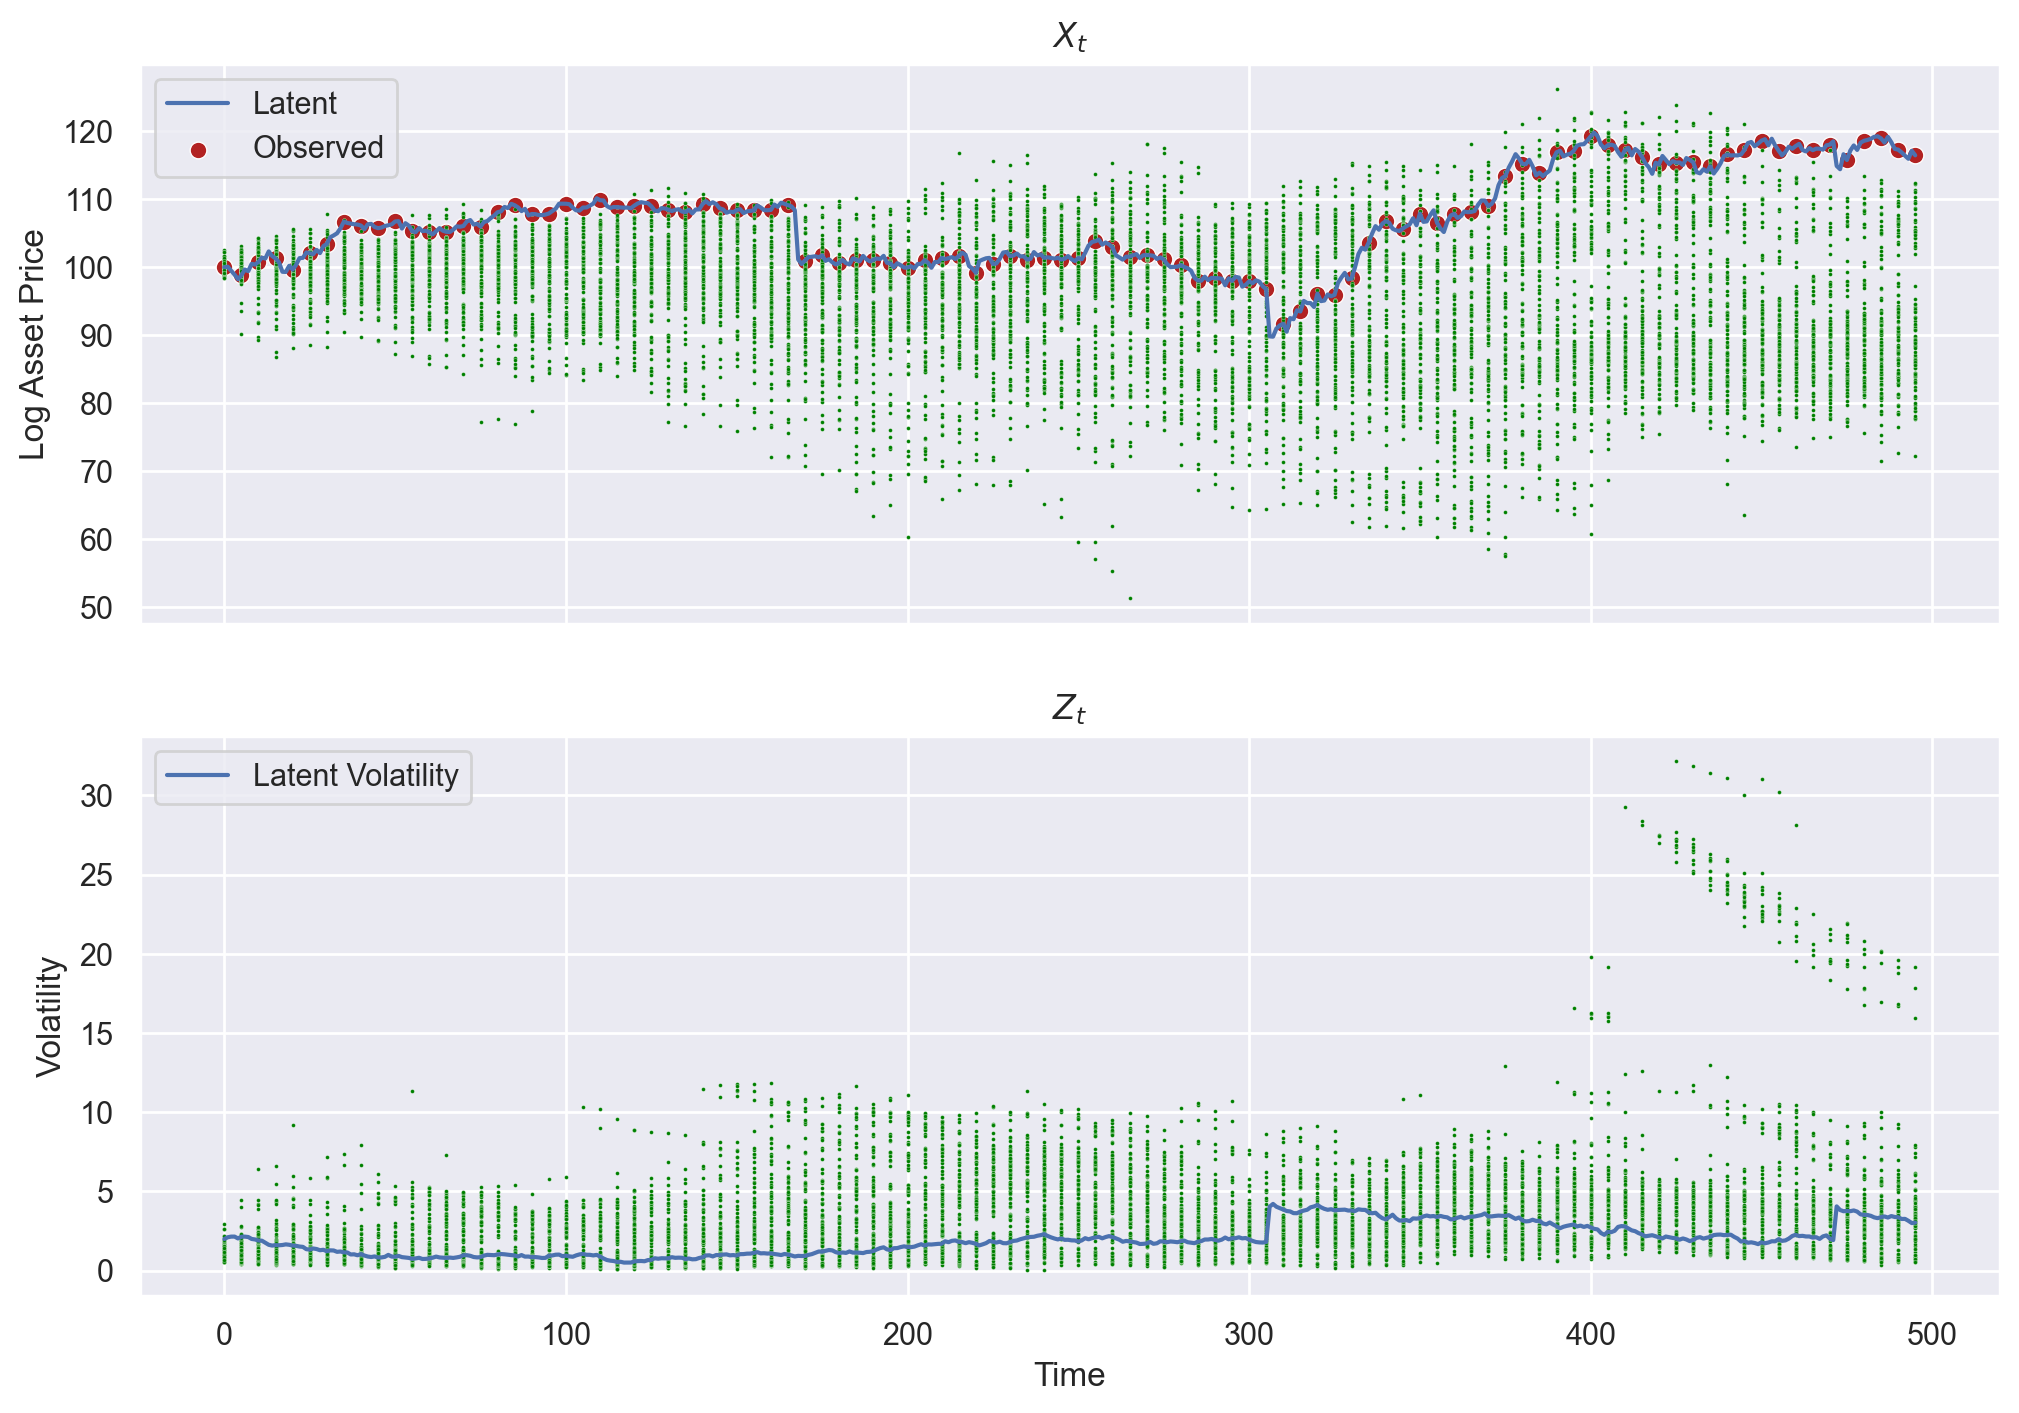

In [222]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");

sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

for t in range(n_obs):
    sns.scatterplot(x = t*n_res, 
                    y=price_particles[t, :], 
                    s = 2, 
                    color = "green", ax = ax[0]);
    sns.scatterplot(x = t*n_res, 
                    y=vol_particles[t, :], 
                    s = 2, 
                    color = "green", ax = ax[1]);